## Dependencies

In [1]:
import os
import sys
import cv2
import shutil
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow import set_random_seed
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from keras import backend as K
from keras.models import Model
from keras.utils import to_categorical
from keras import optimizers, applications
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback, LearningRateScheduler
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input

# Set seeds to make the experiment more reproducible.
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    set_random_seed(0)
seed = 0
seed_everything(seed)

%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

sys.path.append(os.path.abspath('../input/efficientnet/efficientnet-master/efficientnet-master/'))
from efficientnet import *

Using TensorFlow backend.


## Load data

In [2]:
hold_out_set = pd.read_csv('../input/aptos-data-split/hold-out.csv')
X_train = hold_out_set[hold_out_set['set'] == 'train']
X_val = hold_out_set[hold_out_set['set'] == 'validation']
test = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')
print('Number of train samples: ', X_train.shape[0])
print('Number of validation samples: ', X_val.shape[0])
print('Number of test samples: ', test.shape[0])

# Preprocecss data
X_train["id_code"] = X_train["id_code"].apply(lambda x: x + ".png")
X_val["id_code"] = X_val["id_code"].apply(lambda x: x + ".png")
test["id_code"] = test["id_code"].apply(lambda x: x + ".png")
X_train['diagnosis'] = X_train['diagnosis']
X_val['diagnosis'] = X_val['diagnosis']
display(X_train.head())

Number of train samples:  2929
Number of validation samples:  733
Number of test samples:  1928


,id_code,diagnosis,height,width,set
0,55eac26bd383.png,1,1736,2416,train
1,44e0d56e9d42.png,2,2136,3216,train
2,aa4407aab872.png,0,1050,1050,train
3,cffc50047828.png,0,614,819,train
4,b0f0fa677d5f.png,0,1050,1050,train


# Model parameters

In [3]:
# Model parameters
BATCH_SIZE = 16
EPOCHS = 40
WARMUP_EPOCHS = 5
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 320
WIDTH = 320
CHANNELS = 3
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

# Pre-procecess images

In [4]:
train_base_path = '../input/aptos2019-blindness-detection/train_images/'
test_base_path = '../input/aptos2019-blindness-detection/test_images/'
train_dest_path = 'base_dir/train_images/'
validation_dest_path = 'base_dir/validation_images/'
test_dest_path =  'base_dir/test_images/'

# Making sure directories don't exist
if os.path.exists(train_dest_path):
    shutil.rmtree(train_dest_path)
if os.path.exists(validation_dest_path):
    shutil.rmtree(validation_dest_path)
if os.path.exists(test_dest_path):
    shutil.rmtree(test_dest_path)
    
# Creating train, validation and test directories
os.makedirs(train_dest_path)
os.makedirs(validation_dest_path)
os.makedirs(test_dest_path)

def crop_image(img, tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
            
        return img

def circle_crop(img):
    img = crop_image(img)

    height, width, depth = img.shape
    largest_side = np.max((height, width))
    img = cv2.resize(img, (largest_side, largest_side))

    height, width, depth = img.shape

    x = width//2
    y = height//2
    r = np.amin((x, y))

    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x, y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image(img)

    return img
    
def preprocess_image(base_path, save_path, image_id, HEIGHT, WIDTH, sigmaX=10):
    image = cv2.imread(base_path + image_id)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = circle_crop(image)
    image = cv2.resize(image, (HEIGHT, WIDTH))
    image = cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0,0), sigmaX), -4 , 128)
    cv2.imwrite(save_path + image_id, image)
    
# Pre-procecss train set
for i, image_id in enumerate(X_train['id_code']):
    preprocess_image(train_base_path, train_dest_path, image_id, HEIGHT, WIDTH)
    
# Pre-procecss validation set
for i, image_id in enumerate(X_val['id_code']):
    preprocess_image(train_base_path, validation_dest_path, image_id, HEIGHT, WIDTH)
    
# Pre-procecss test set
for i, image_id in enumerate(test['id_code']):
    preprocess_image(test_base_path, test_dest_path, image_id, HEIGHT, WIDTH)

# Data generator

In [5]:
datagen=ImageDataGenerator(rescale=1./255, 
                           rotation_range=360,
                           horizontal_flip=True,
                           vertical_flip=True)

train_generator=datagen.flow_from_dataframe(
                          dataframe=X_train,
                          directory=train_dest_path,
                          x_col="id_code",
                          y_col="diagnosis",
                          class_mode="raw",
                          batch_size=BATCH_SIZE,
                          target_size=(HEIGHT, WIDTH),
                          seed=seed)

valid_generator=datagen.flow_from_dataframe(
                        dataframe=X_val,
                        directory=validation_dest_path,
                        x_col="id_code",
                        y_col="diagnosis",
                        class_mode="raw",
                        batch_size=BATCH_SIZE,
                        target_size=(HEIGHT, WIDTH),
                        seed=seed)

test_generator=datagen.flow_from_dataframe(  
                          dataframe=test,
                          directory=test_dest_path,
                          x_col="id_code",
                          batch_size=1,
                          class_mode=None,
                          shuffle=False,
                          target_size=(HEIGHT, WIDTH),
                          seed=seed)

Found 2929 validated image filenames.
Found 733 validated image filenames.
Found 1928 validated image filenames.


# Model

In [6]:
def create_model(input_shape):
    input_tensor = Input(shape=input_shape)
    base_model = EfficientNetB0(weights=None, 
                                include_top=False,
                                input_tensor=input_tensor)
    base_model.load_weights('../input/efficientnet-keras-weights-b0b5/efficientnet-b0_imagenet_1000_notop.h5')


    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)
    final_output = Dense(1, activation='linear', name='final_output')(x)
    model = Model(input_tensor, final_output)
    
    return model

# Train top layers

In [7]:
model = create_model(input_shape=(HEIGHT, WIDTH, CHANNELS))

for layer in model.layers:
    layer.trainable = False

for i in range(-5, 0):
    model.layers[i].trainable = True
    
metric_list = ["accuracy"]
optimizer = optimizers.Adam(lr=WARMUP_LEARNING_RATE)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=metric_list)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 320, 320, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 160, 160, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 160, 160, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
swish_1 (Swish)                 (None, 160, 160, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
depthwise_

In [8]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

history_warmup = model.fit_generator(generator=train_generator,
                                     steps_per_epoch=STEP_SIZE_TRAIN,
                                     validation_data=valid_generator,
                                     validation_steps=STEP_SIZE_VALID,
                                     epochs=WARMUP_EPOCHS,
                                     verbose=1).history

Epoch 1/5
183/183 [==============================] - 82s 449ms/step - loss: 1.0998 - acc: 0.4320 - val_loss: 2.1906 - val_acc: 0.4542
Epoch 2/5
183/183 [==============================] - 75s 412ms/step - loss: 0.8482 - acc: 0.5116 - val_loss: 1.2205 - val_acc: 0.3570
Epoch 3/5
183/183 [==============================] - 75s 408ms/step - loss: 0.7945 - acc: 0.5188 - val_loss: 1.9080 - val_acc: 0.5077
Epoch 4/5
183/183 [==============================] - 75s 408ms/step - loss: 0.7470 - acc: 0.5506 - val_loss: 1.6380 - val_acc: 0.4128
Epoch 5/5
183/183 [==============================] - 75s 407ms/step - loss: 0.7317 - acc: 0.5509 - val_loss: 1.3363 - val_acc: 0.2706


# Fine-tune the complete model (1st step)

In [9]:
for layer in model.layers:
    layer.trainable = True

es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callback_list = [es, rlrop]
optimizer = optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=metric_list)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 320, 320, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 160, 160, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 160, 160, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
swish_1 (Swish)                 (None, 160, 160, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
depthwise_

In [10]:
history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=STEP_SIZE_TRAIN,
                                          validation_data=valid_generator,
                                          validation_steps=STEP_SIZE_VALID,
                                          epochs=int(EPOCHS*0.8),
                                          callbacks=callback_list,
                                          verbose=1).history

Epoch 1/32
183/183 [==============================] - 104s 570ms/step - loss: 0.7054 - acc: 0.5926 - val_loss: 0.4771 - val_acc: 0.6611
Epoch 2/32
183/183 [==============================] - 89s 484ms/step - loss: 0.5064 - acc: 0.6407 - val_loss: 0.4819 - val_acc: 0.6974
Epoch 3/32
183/183 [==============================] - 89s 487ms/step - loss: 0.4485 - acc: 0.6721 - val_loss: 0.4212 - val_acc: 0.7169
Epoch 4/32
183/183 [==============================] - 89s 488ms/step - loss: 0.4024 - acc: 0.7076 - val_loss: 0.3737 - val_acc: 0.7531
Epoch 5/32
183/183 [==============================] - 89s 487ms/step - loss: 0.3791 - acc: 0.7128 - val_loss: 0.3695 - val_acc: 0.7629
Epoch 6/32
183/183 [==============================] - 91s 495ms/step - loss: 0.3555 - acc: 0.7364 - val_loss: 0.3524 - val_acc: 0.7545
Epoch 7/32
183/183 [==============================] - 91s 498ms/step - loss: 0.3256 - acc: 0.7319 - val_loss: 0.4631 - val_acc: 0.7378
Epoch 8/32
183/183 [==============================] - 

# Fine-tune the complete model (2nd step)

In [11]:
optimizer = optimizers.SGD(lr=LEARNING_RATE, momentum=0.9, nesterov=True)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=metric_list)

In [12]:
history_finetunning_2 = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=STEP_SIZE_TRAIN,
                                          validation_data=valid_generator,
                                          validation_steps=STEP_SIZE_VALID,
                                          epochs=int(EPOCHS*0.2),
                                          callbacks=callback_list,
                                          verbose=1).history

Epoch 1/8
183/183 [==============================] - 99s 541ms/step - loss: 0.1975 - acc: 0.8125 - val_loss: 0.3328 - val_acc: 0.7741
Epoch 2/8
183/183 [==============================] - 88s 479ms/step - loss: 0.2180 - acc: 0.7872 - val_loss: 0.3244 - val_acc: 0.7936
Epoch 3/8
183/183 [==============================] - 88s 481ms/step - loss: 0.2040 - acc: 0.7968 - val_loss: 0.2648 - val_acc: 0.8075
Epoch 4/8
183/183 [==============================] - 87s 476ms/step - loss: 0.2127 - acc: 0.7995 - val_loss: 0.3987 - val_acc: 0.7657
Epoch 5/8
183/183 [==============================] - 87s 475ms/step - loss: 0.2120 - acc: 0.8026 - val_loss: 0.3054 - val_acc: 0.7950
Epoch 6/8
183/183 [==============================] - 88s 481ms/step - loss: 0.2771 - acc: 0.7985 - val_loss: 0.3020 - val_acc: 0.7978

Epoch 00006: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Epoch 7/8
183/183 [==============================] - 86s 473ms/step - loss: 0.2011 - acc: 0.8036 - val_loss: 0.3151

# Model loss graph 

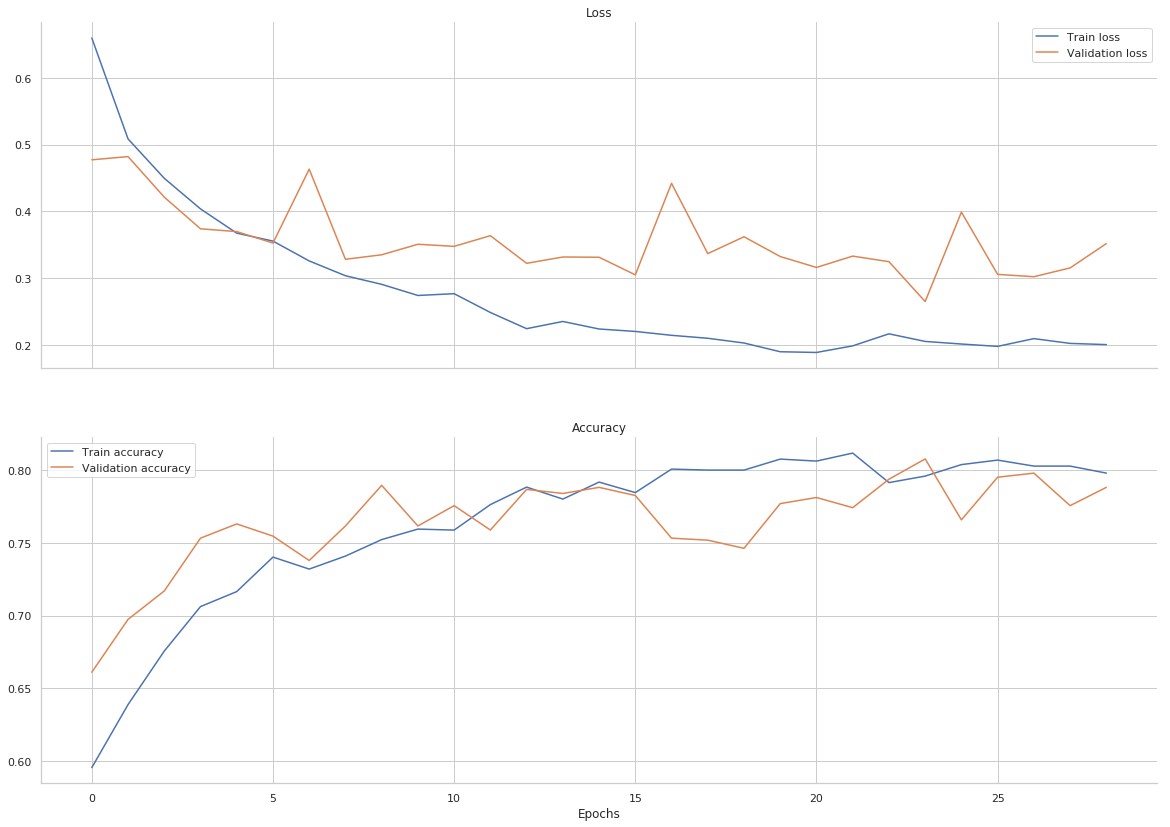

In [13]:
history = {'loss': history_finetunning['loss'] + history_finetunning_2['loss'], 
           'val_loss': history_finetunning['val_loss'] + history_finetunning_2['val_loss'], 
           'acc': history_finetunning['acc'] + history_finetunning_2['acc'], 
           'val_acc': history_finetunning['val_acc'] + history_finetunning_2['val_acc']}

sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Train loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['acc'], label='Train accuracy')
ax2.plot(history['val_acc'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('Accuracy')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [14]:
# Create empty arays to keep the predictions and labels
df_preds = pd.DataFrame(columns=['label', 'pred', 'set'])
train_generator.reset()
valid_generator.reset()

# Add train predictions and labels
for i in range(STEP_SIZE_TRAIN + 1):
    im, lbl = next(train_generator)
    preds = model.predict(im, batch_size=train_generator.batch_size)
    for index in range(len(preds)):
        df_preds.loc[len(df_preds)] = [lbl[index], preds[index][0], 'train']

# Add validation predictions and labels
for i in range(STEP_SIZE_VALID + 1):
    im, lbl = next(valid_generator)
    preds = model.predict(im, batch_size=valid_generator.batch_size)
    for index in range(len(preds)):
        df_preds.loc[len(df_preds)] = [lbl[index], preds[index][0], 'validation']

df_preds['label'] = df_preds['label'].astype('int')

# Threshold optimization

Label 3: thr=0.00, Kappa=0.776


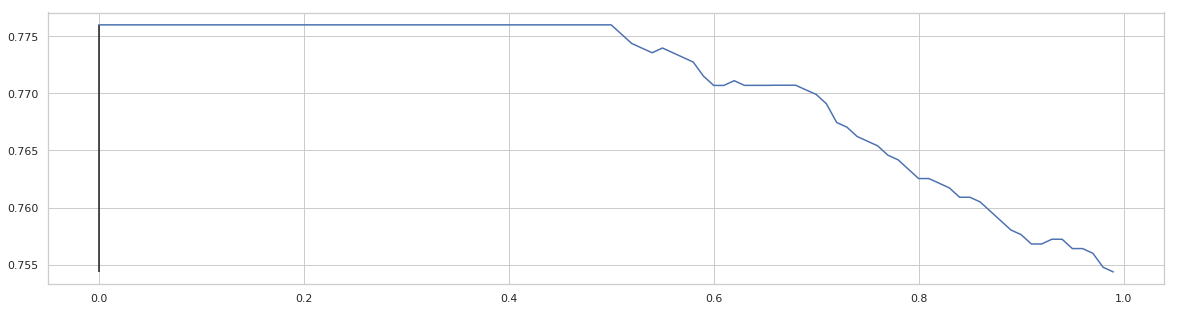

Label 2: thr=0.58, Kappa=0.777


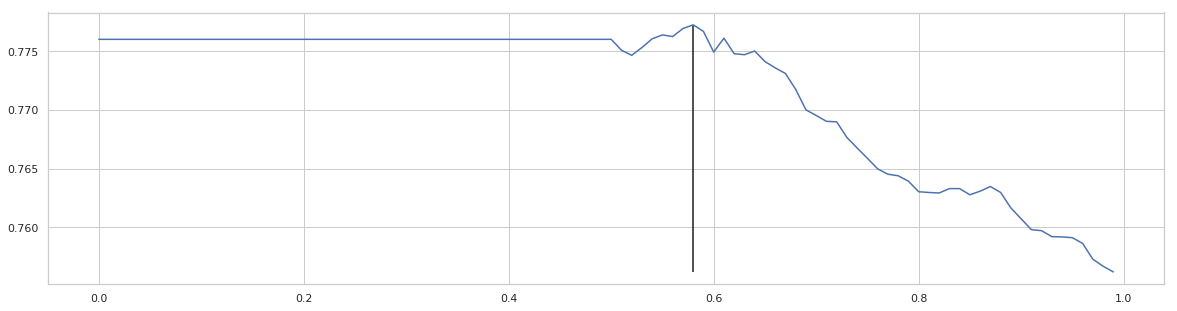

Label 1: thr=0.00, Kappa=0.776


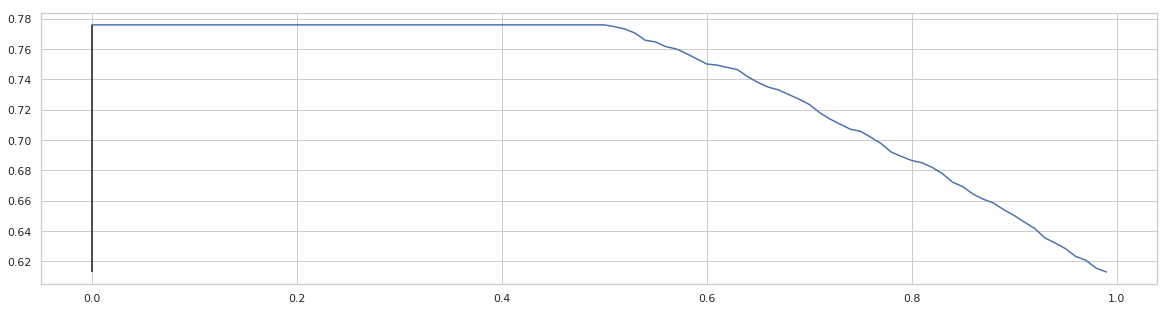

Label 0: thr=0.00, Kappa=0.776


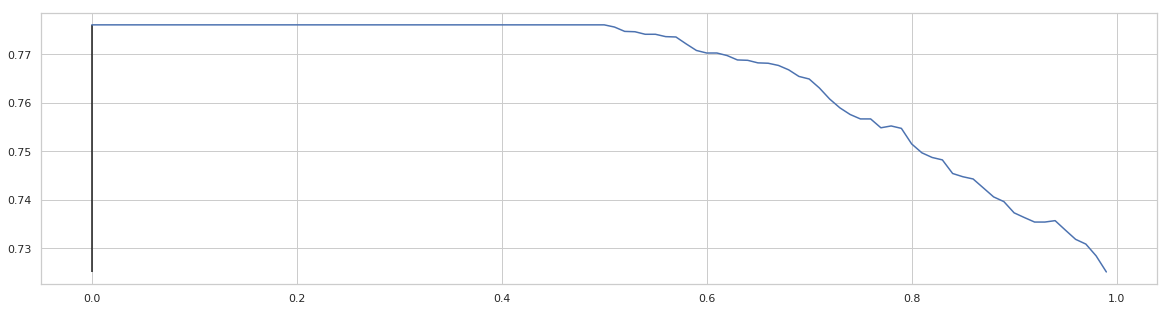

In [15]:
def classify(x):
    if x < 0.5:
        return 0
    elif x < 1.5:
        return 1
    elif x < 2.5:
        return 2
    elif x < 3.5:
        return 3
    return 4

def classify_opt(x):
    if x <= (0 + best_thr_0):
        return 0
    elif x <= (1 + best_thr_1):
        return 1
    elif x <= (2 + best_thr_2):
        return 2
    elif x <= (3 + best_thr_3):
        return 3
    return 4


def find_best_threshold(df, label, label_col='label', pred_col='pred', do_plot=True):
    score = []
    thrs = np.arange(0, 1, 0.01)
    for thr in thrs:
        preds_thr = [label if ((pred >= label and pred < label+1) and (pred < (label+thr))) else classify(pred) for pred in df[pred_col]]
        score.append(cohen_kappa_score(df[label_col].astype('int'), preds_thr))

    score = np.array(score)
    pm = score.argmax()
    best_thr, best_score = thrs[pm], score[pm].item()
    print('Label %s: thr=%.2f, Kappa=%.3f' % (label, best_thr, best_score))
    plt.rcParams["figure.figsize"] = (20, 5)
    plt.plot(thrs, score)
    plt.vlines(x=best_thr, ymin=score.min(), ymax=score.max())
    plt.show()
    
    return best_thr

# Best threshold for label 3
best_thr_3 = find_best_threshold(df_preds, 3)

# Best threshold for label 2
best_thr_2 = find_best_threshold(df_preds, 2)

# Best threshold for label 1
best_thr_1 = find_best_threshold(df_preds, 1)

# Best threshold for label 0
best_thr_0 = find_best_threshold(df_preds, 0)

In [16]:
# Classify predictions
df_preds['predictions'] = df_preds['pred'].apply(lambda x: classify(x))
# Apply optimized thresholds to the predictions
df_preds['predictions_opt'] = df_preds['pred'].apply(lambda x: classify_opt(x))

train_preds = df_preds[df_preds['set'] == 'train']
validation_preds = df_preds[df_preds['set'] == 'validation']

# Model Evaluation

## Confusion Matrix

### Original thresholds

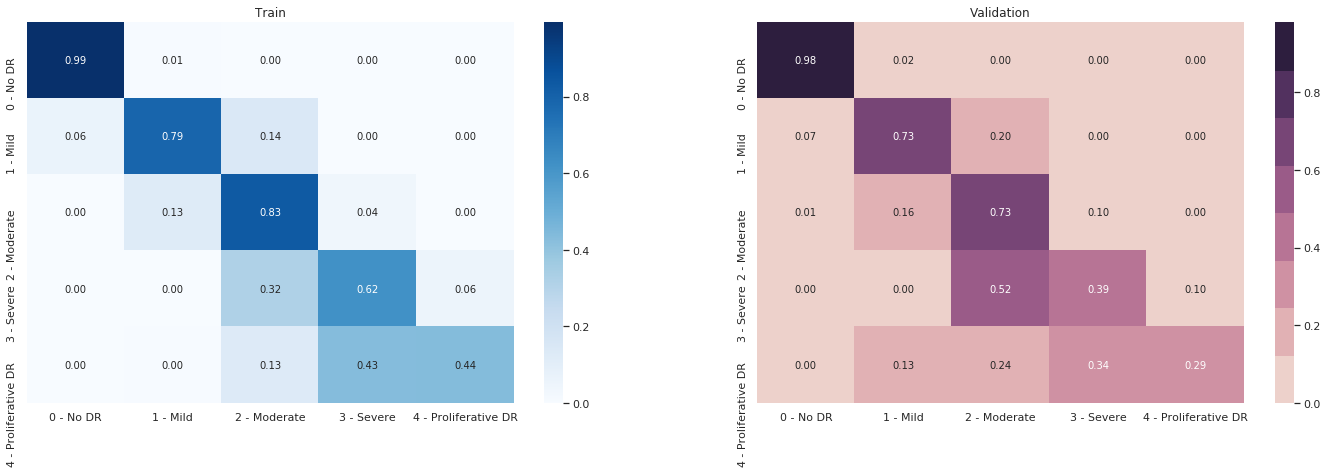

In [17]:
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
def plot_confusion_matrix(train, validation, labels=labels):
    train_labels, train_preds = train
    validation_labels, validation_preds = validation
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', figsize=(24, 7))
    train_cnf_matrix = confusion_matrix(train_labels, train_preds)
    validation_cnf_matrix = confusion_matrix(validation_labels, validation_preds)

    train_cnf_matrix_norm = train_cnf_matrix.astype('float') / train_cnf_matrix.sum(axis=1)[:, np.newaxis]
    validation_cnf_matrix_norm = validation_cnf_matrix.astype('float') / validation_cnf_matrix.sum(axis=1)[:, np.newaxis]

    train_df_cm = pd.DataFrame(train_cnf_matrix_norm, index=labels, columns=labels)
    validation_df_cm = pd.DataFrame(validation_cnf_matrix_norm, index=labels, columns=labels)

    sns.heatmap(train_df_cm, annot=True, fmt='.2f', cmap="Blues",ax=ax1).set_title('Train')
    sns.heatmap(validation_df_cm, annot=True, fmt='.2f', cmap=sns.cubehelix_palette(8),ax=ax2).set_title('Validation')
    plt.show()

plot_confusion_matrix((train_preds['label'], train_preds['predictions']), (validation_preds['label'], validation_preds['predictions']))

### Optimized thresholds

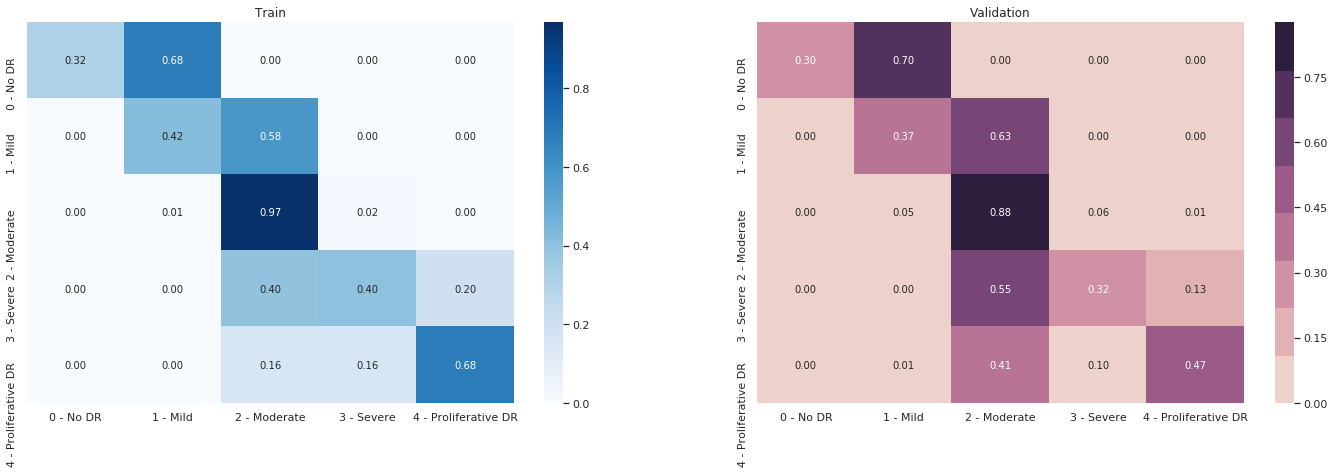

In [18]:
plot_confusion_matrix((train_preds['label'], train_preds['predictions_opt']), (validation_preds['label'], validation_preds['predictions_opt']))

## Quadratic Weighted Kappa

In [19]:
def evaluate_model(train, validation):
    train_labels, train_preds = train
    validation_labels, validation_preds = validation
    print("Train        Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds, train_labels, weights='quadratic'))
    print("Validation   Cohen Kappa score: %.3f" % cohen_kappa_score(validation_preds, validation_labels, weights='quadratic'))
    print("Complete set Cohen Kappa score: %.3f" % cohen_kappa_score(np.append(train_preds, validation_preds), np.append(train_labels, validation_labels), weights='quadratic'))
    
print("   Original thresholds")
evaluate_model((train_preds['label'], train_preds['predictions']), (validation_preds['label'], validation_preds['predictions']))
print("   Optimized thresholds")
evaluate_model((train_preds['label'], train_preds['predictions_opt']), (validation_preds['label'], validation_preds['predictions_opt']))

   Original thresholds
Train        Cohen Kappa score: 0.946
Validation   Cohen Kappa score: 0.876
Complete set Cohen Kappa score: 0.932
   Optimized thresholds
Train        Cohen Kappa score: 0.822
Validation   Cohen Kappa score: 0.767
Complete set Cohen Kappa score: 0.811


## Apply model to test set and output predictions

In [20]:
def apply_tta(model, generator, steps=5):
    step_size = generator.n//generator.batch_size
    preds_tta = []
    for i in range(steps):
        generator.reset()
        preds = model.predict_generator(generator, steps=step_size)
        preds_tta.append(preds)

    return np.mean(preds_tta, axis=0)

preds = apply_tta(model, test_generator)
predictions = [classify(x) for x in preds]
predictions_opt = [classify_opt(x) for x in preds]

results = pd.DataFrame({'id_code':test['id_code'], 'diagnosis':predictions})
results['id_code'] = results['id_code'].map(lambda x: str(x)[:-4])

results_opt = pd.DataFrame({'id_code':test['id_code'], 'diagnosis':predictions_opt})
results_opt['id_code'] = results_opt['id_code'].map(lambda x: str(x)[:-4])

In [21]:
# Cleaning created directories
if os.path.exists(train_dest_path):
    shutil.rmtree(train_dest_path)
if os.path.exists(validation_dest_path):
    shutil.rmtree(validation_dest_path)
if os.path.exists(test_dest_path):
    shutil.rmtree(test_dest_path)

# Predictions class distribution

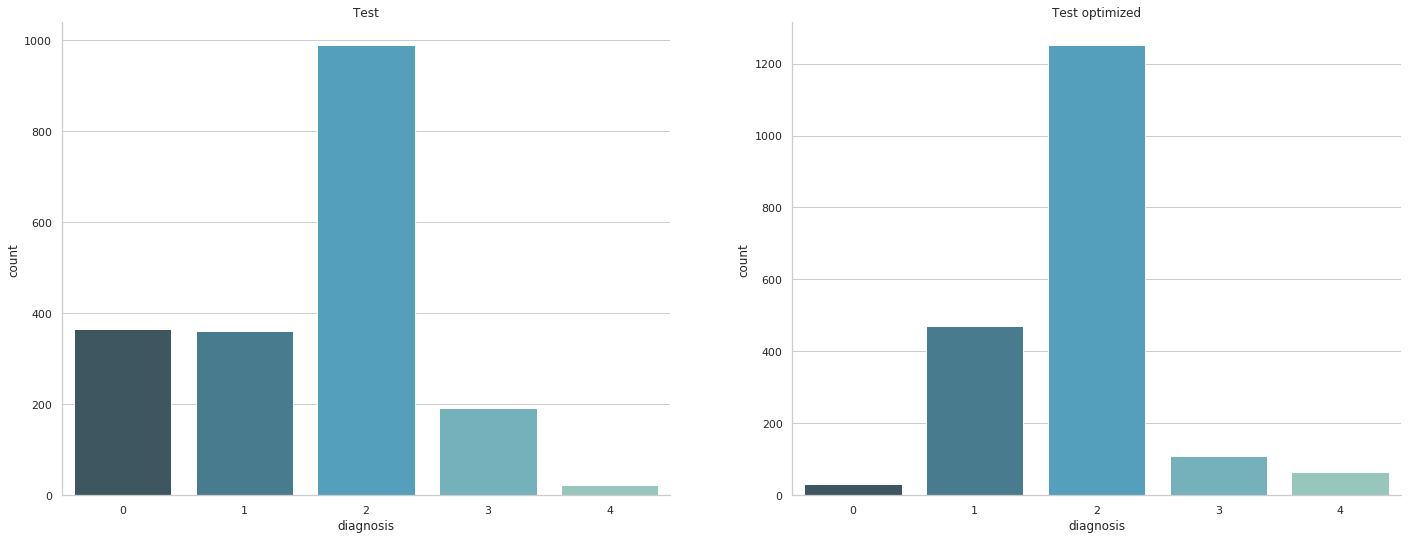

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', figsize=(24, 8.7))
sns.countplot(x="diagnosis", data=results, palette="GnBu_d", ax=ax1).set_title('Test')
sns.countplot(x="diagnosis", data=results_opt, palette="GnBu_d", ax=ax2).set_title('Test optimized')
sns.despine()
plt.show()

In [23]:
val_kappa =  cohen_kappa_score(validation_preds['label'], validation_preds['predictions'], weights='quadratic')
val_opt_kappa = cohen_kappa_score(validation_preds['label'], validation_preds['predictions_opt'], weights='quadratic')
results_name = 'submission.csv'
results_opt_name = 'submission_opt.csv'

# if val_kappa > val_opt_kappa:
#     results_name = 'submission.csv'
#     results_opt_name = 'submission_opt.csv'
# else:
#     results_name = 'submission_norm.csv'
#     results_opt_name = 'submission.csv'

In [24]:
results.to_csv(results_name, index=False)
display(results.head())

results_opt.to_csv(results_opt_name, index=False)
display(results_opt.head())

,id_code,diagnosis
0,0005cfc8afb6,2
1,003f0afdcd15,2
2,006efc72b638,2
3,00836aaacf06,2
4,009245722fa4,1


,id_code,diagnosis
0,0005cfc8afb6,2
1,003f0afdcd15,2
2,006efc72b638,2
3,00836aaacf06,2
4,009245722fa4,2
